#   MLflow model using ElasticNet (sklearn) and Plots ElasticNet Descent Paths
- Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
- The predicted "progression" column is a quantitative measure of disease progression one year after baseline http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
- Combines the above with the Lasso Coordinate Descent Path Plot http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html
- Original author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
- License: BSD 3 clause

In [1]:
%matplotlib inline
import os, warnings, sys
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

In [2]:
# Load Diabetes datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Create pandas DataFrame for sklearn ElasticNet linear_model
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = diabetes.feature_names + ['progression']
data = pd.DataFrame(d, columns=cols)

In [3]:
# Import mlflow
import mlflow
import mlflow.sklearn

In [4]:
# Evaluate metrics
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [5]:
np.random.seed(40)

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
train_x = train.drop(["progression"], axis=1)
test_x = test.drop(["progression"], axis=1)
train_y = train[["progression"]]
test_y = test[["progression"]]

In [6]:
alpha =  0.05
l1_ratio = 0.05

# Run ElasticNet
lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
lr.fit(train_x, train_y)
predicted_qualities = lr.predict(test_x)
(rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

In [7]:
# Print out ElasticNet model metrics
print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

# Log mlflow attributes for mlflow UI
mlflow.log_param("alpha", alpha)
mlflow.log_param("l1_ratio", l1_ratio)
mlflow.log_metric("rmse", rmse)
mlflow.log_metric("r2", r2)
mlflow.log_metric("mae", mae)
mlflow.sklearn.log_model(lr, "model")

Elasticnet model (alpha=0.050000, l1_ratio=0.050000):
  RMSE: 78.59248628523486
  MAE: 66.30996047256438
  R2: 0.06607454600721252


In [8]:
# Compute paths
eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the elastic net.")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

Computing regularization path using the elastic net.


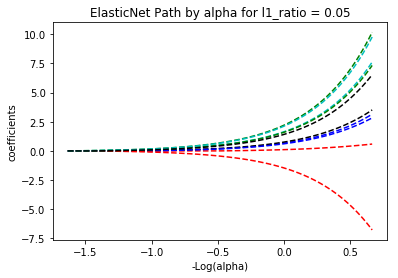

In [9]:
# Display results
fig = plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_e, c in zip(coefs_enet, colors):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
plt.title(title)
plt.axis('tight')


# Save figures
fig.savefig("ElasticNet-paths.png")

In [10]:
# Log artifacts (output files)
mlflow.log_artifact("ElasticNet-paths.png")